# HW4

In [1]:
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as my_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from keras.layers import SimpleRNN,LSTM,CuDNNGRU,CuDNNLSTM,Conv1D,MaxPooling1D,Dropout
from keras import regularizers
from keras.layers import BatchNormalization
from keras import optimizers
from keras import initializers

from keras.callbacks import *
from keras import backend as K

from keras.callbacks import *
from keras.optimizers import Adam

import keras

import re

import nltk

In [2]:
from keras.utils import to_categorical

In [3]:
#pip install --upgrade nltk

## Load Data

In [4]:
data = pd.read_csv('Reviews.csv')

## Data Preprocessing

In [5]:
data = data.head(10000)
data = data[['Text','Score']]
data['Score'] = data['Score'].apply(lambda x:1 if x>=4 else 0)
data['Text'] = data['Text'].apply(lambda x: x.replace('.', ''))

In [6]:
data.head(10)

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price There was a wide...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1
7,This taffy is so good It is very soft and che...,1
8,Right now I'm mostly just sprouting this so my...,1
9,This is a very healthy dog food Good for their...,1


## Clean the Words

In [7]:
#Define a pattern
pat1= '#[^ ]+'
pat2 = 'www.[^ ]+'
pat3 = '@[^ ]+'
pat4 = '[0-9]+'
pat5 = 'http[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}


pattern = '|'.join((pat1,pat2,pat3,pat4,pat5))
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [8]:
#Cleaning Data and removing Stop Words
stop_words = stopwords.words('english')
clean_words = []

In [9]:
#start to clean words
for t in data['Text']:
    t = t.lower()
    t = re.sub(pattern,'',t)
    t = neg_pattern.sub(lambda x: negations_dic[x.group()], t)
    t = word_tokenize(t)
    t = [x for x in t if len(x) >1]
    t = [x for x in t if x not in stop_words]
    t = [x for x in t if x.isalpha()]
    t = " ".join(t)
    t = re.sub("n't","not",t)
    t = re.sub("'s","is",t)
    clean_words.append(t)

In [10]:
df_clean = pd.DataFrame(clean_words,columns = ['text'])
df_clean['score']=data['Score']

In [11]:
df_clean.head(10)

,text,score
0,bought several vitality canned dog food produc...,1
1,product arrived labeled jumbo salted peanutsth...,0
2,confection around centuries light pillowy citr...,1
3,looking secret ingredient robitussin believe f...,0
4,great taffy great price wide assortment yummy ...,1
5,got wild hair taffy ordered five pound bag taf...,1
6,saltwater taffy great flavors soft chewy candy...,1
7,taffy good soft chewy flavors amazing would de...,1
8,right mostly sprouting cats eat grass love rot...,1
9,healthy dog food good digestion also good smal...,1


## Build Tokens

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
from sklearn.model_selection import train_test_split
y = df_clean['score']
df_train,df_test,y_train,y_test=train_test_split(df_clean['text'],y,test_size=0.33,random_state=42)
print('DF Train Shape: ',df_train.shape)
print('DF Test Shape: ',df_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

DF Train Shape:  (6700,)
DF Test Shape:  (3300,)
Y Train Shape:  (6700,)
Y Test Shape:  (3300,)


In [14]:
max_words=1000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)

#texts_to_sequences: vectorize a text corpus, by turning each text into either a sequence of integers
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_test=tokenizer.texts_to_sequences(df_test)

In [15]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('Dataset has %s number of independent tokens' %V)

Dataset has 15415 number of independent tokens


In [16]:
#transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). 
data_train=pad_sequences(sequence_train)
T=data_train.shape[1] # T means num_timesteps
data_test=pad_sequences(sequence_test,maxlen=T)

## Build CNN Models

In [17]:
T

403

In [18]:
D=10
# instantiate a Keras tensor
i=Input((T,))

### Baseline

In [19]:
x= Sequential()
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_split=0.2 ,epochs=5,batch_size=100)
y_pred=model.predict(data_test)
y_pred=np.argmax(y_pred,axis=1)

scores = model.evaluate(data_test, y_test,verbose=1)
print(scores[1])

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 403)]             0         
                                                                 
 embedding (Embedding)       (None, 403, 10)           154160    
                                                                 
 conv1d (Conv1D)             (None, 401, 32)           992       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 133, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 131, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 64)           0         
 1D)                           

2022-12-01 23:19:56.585964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 23:19:56.586072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-01 23:19:56.726112: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 23:19:56.996544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 14s 251ms/step - loss: 0.8213 - accuracy: 0.7593 - val_loss: 0.5512 - val_accuracy: 0.7604
Epoch 2/5


2022-12-01 23:20:10.531163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 13s 235ms/step - loss: 0.5509 - accuracy: 0.7593 - val_loss: 0.5475 - val_accuracy: 0.7604
Epoch 3/5
54/54 [==============================] - 11s 207ms/step - loss: 0.5444 - accuracy: 0.7593 - val_loss: 0.5376 - val_accuracy: 0.7604
Epoch 4/5
54/54 [==============================] - 12s 231ms/step - loss: 0.5180 - accuracy: 0.7593 - val_loss: 0.5161 - val_accuracy: 0.7604
Epoch 5/5
 61/104 [================>.............] - ETA: 0s

2022-12-01 23:20:53.786684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 1s 5ms/step - loss: 0.4748 - accuracy: 0.7839
0.7839394211769104


### Add Dropout = 0.7

In [21]:
x= Sequential()
x= Dropout(0.7)
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
modelCNN=Model(i,x)
print(modelCNN.summary())

modelCNN.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=modelCNN.fit(data_train,y_train,validation_split=0.2 ,epochs=5,batch_size=100)
y_pred_cnn=modelCNN.predict(data_test)
y_pred_cnn=np.argmax(y_pred_cnn,axis=1)

scores = model.evaluate(data_test, y_test,verbose=1)
print(scores[1])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 403)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 403, 10)           154160    
                                                                 
 conv1d_6 (Conv1D)           (None, 401, 32)           992       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 133, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 131, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 43, 64)           0         
 1D)                                                       

2022-12-01 23:22:10.518118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.7591

2022-12-01 23:22:23.538687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 13s 243ms/step - loss: 0.7975 - accuracy: 0.7591 - val_loss: 0.5509 - val_accuracy: 0.7604
Epoch 2/5
54/54 [==============================] - 13s 250ms/step - loss: 0.5550 - accuracy: 0.7593 - val_loss: 0.5487 - val_accuracy: 0.7604
Epoch 3/5
54/54 [==============================] - 13s 242ms/step - loss: 0.5527 - accuracy: 0.7593 - val_loss: 0.5438 - val_accuracy: 0.7604
Epoch 4/5
54/54 [==============================] - 13s 242ms/step - loss: 0.5110 - accuracy: 0.7593 - val_loss: 0.4903 - val_accuracy: 0.7619
Epoch 5/5
 54/104 [==============>...............] - ETA: 0s

2022-12-01 23:23:13.514443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 1s 5ms/step - loss: 0.4748 - accuracy: 0.7839
0.7839394211769104


## Build LSTM Models

In [25]:
label = 1
#y_train_c = to_categorical(y_train, label)
#y_test_c = to_categorical(y_test, label)


embed_dim = 80
lstm_out = 128

modelLSTM = Sequential()
modelLSTM.add(Embedding(max_words, embed_dim,input_length = T))
modelLSTM.add(Dropout(0.7))
modelLSTM.add(LSTM(lstm_out, dropout=0.2)) #, recurrent_dropout=0.2
modelLSTM.add(Dense(label,activation='softmax'))
modelLSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modelLSTM.summary())

LSTM_senti = modelLSTM.fit(data_train,y_train, 
                           epochs=5, 
                           batch_size=128,
                           validation_split=0.2 )

y_pred_LSTM=modelLSTM.predict(data_test)
y_pred_LSTM=np.argmax(y_pred_LSTM,axis=1)

scores = model.evaluate(data_test, y_test,verbose=1)
print(scores[1])

In [36]:
label = 3
y_train_c = to_categorical(y_train, label)

embed_dim = 80
lstm_out = 128

modelLSTM = Sequential()
modelLSTM.add(Embedding(max_words, embed_dim,input_length = T))
modelLSTM.add(Dropout(0.7))
modelLSTM.add(LSTM(lstm_out, dropout=0.2)) #, recurrent_dropout=0.2
modelLSTM.add(Dense(label,activation='softmax'))
modelLSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modelLSTM.summary())

LSTM_senti = modelLSTM.fit(data_train,y_train_c, 
                           epochs=5, 
                           batch_size=128,
                           validation_split=0.2 )

y_pred_LSTM=modelLSTM.predict(data_test)
y_pred_LSTM=np.argmax(y_pred_LSTM,axis=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 403, 80)           80000     
                                                                 
 dropout_4 (Dropout)         (None, 403, 80)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               107008    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 187,395
Trainable params: 187,395
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


2022-12-01 23:31:18.327680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 23:31:18.470157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 23:31:19.062924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.7382

2022-12-01 23:31:29.356456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 23:31:29.398737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 14s 253ms/step - loss: 0.7575 - accuracy: 0.7382 - val_loss: 0.5633 - val_accuracy: 0.7604
Epoch 2/5
42/42 [==============================] - 7s 175ms/step - loss: 0.5287 - accuracy: 0.7593 - val_loss: 0.5185 - val_accuracy: 0.7604
Epoch 3/5
42/42 [==============================] - 8s 181ms/step - loss: 0.4215 - accuracy: 0.8050 - val_loss: 0.4273 - val_accuracy: 0.8209
Epoch 4/5
42/42 [==============================] - 8s 180ms/step - loss: 0.3591 - accuracy: 0.8437 - val_loss: 0.5287 - val_accuracy: 0.7336
Epoch 5/5
42/42 [==============================] - 7s 179ms/step - loss: 0.3368 - accuracy: 0.8522 - val_loss: 0.4106 - val_accuracy: 0.8284


2022-12-01 23:32:01.081681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 23:32:01.119102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 6s 49ms/step


In [37]:
scores = model.evaluate(data_test, y_test,verbose=1)
print(scores[1])

104/104 [==============================] - 1s 5ms/step - loss: 0.4748 - accuracy: 0.7839
0.7839394211769104


## Plot

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

In [28]:
#y_test

Text(50.722222222222214, 0.5, 'y_pred_cnn')

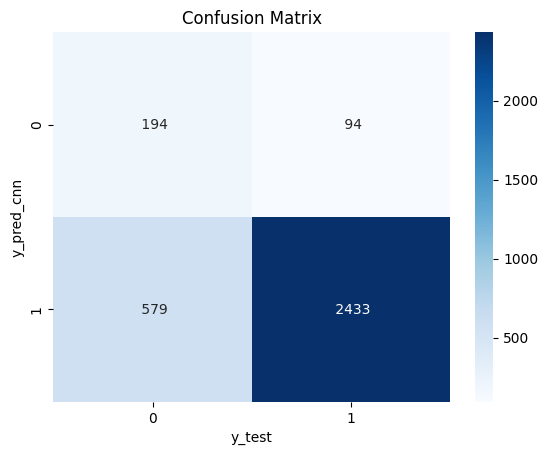

In [48]:
cm=confusion_matrix(y_pred_cnn,y_test)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred_cnn')

Text(50.722222222222214, 0.5, 'y_pred_LSTM')

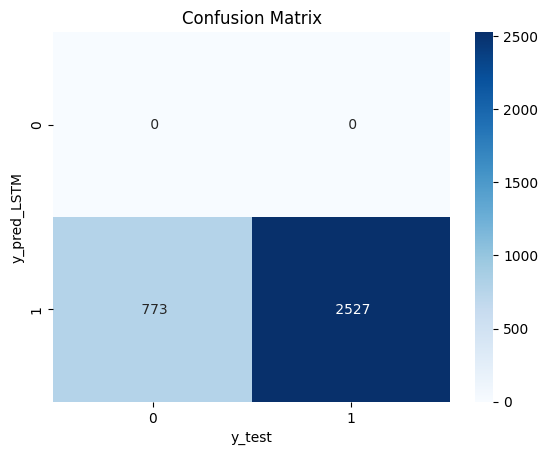

In [49]:
cm=confusion_matrix(y_pred_LSTM,y_test)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred_LSTM')

In [47]:
list(y_pred_cnn).count(1)

3012

In [31]:
def plotModelProcess(epochNum, accuracy, loss):

  # 使用 Epoch 當做X軸資料
  eachEpoch = [i for i in range(epochNum)]

  # 設定圖片大小為長15、寬10

  plt.figure(figsize=(15,10),dpi=100,linewidth = 2)

  # 把資料放進來並指定對應的X軸、Y軸的資料，用方形做標記(s-)，並指定線條顏色為紅色，使用label標記線條含意

  plt.plot(eachEpoch,accuracy,'s-',color = 'r', label="Accuracy")

  # 把資料放進來並指定對應的X軸、Y軸的資料 用圓形做標記(o-)，並指定線條顏色為綠色、使用label標記線條含意

  plt.plot(eachEpoch,loss,'o-',color = 'g', label="Loss")

  # 設定圖片標題，以及指定字型設定，x代表與圖案最左側的距離，y代表與圖片的距離
  plt.title("The Accuracy and Loss of training process", x=0.5, y=1.03)

  # 設定刻度字體大小
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  # 標示x軸(labelpad代表與圖片的距離)
  plt.xlabel("Epoch", fontsize=30, labelpad = 15)

  # 標示y軸(labelpad代表與圖片的距離)
  plt.ylabel("percentage", fontsize=30, labelpad = 20)

  # 顯示出線條標記位置
  plt.legend(loc = "best", fontsize=20)

  # 畫出圖片
  plt.show()

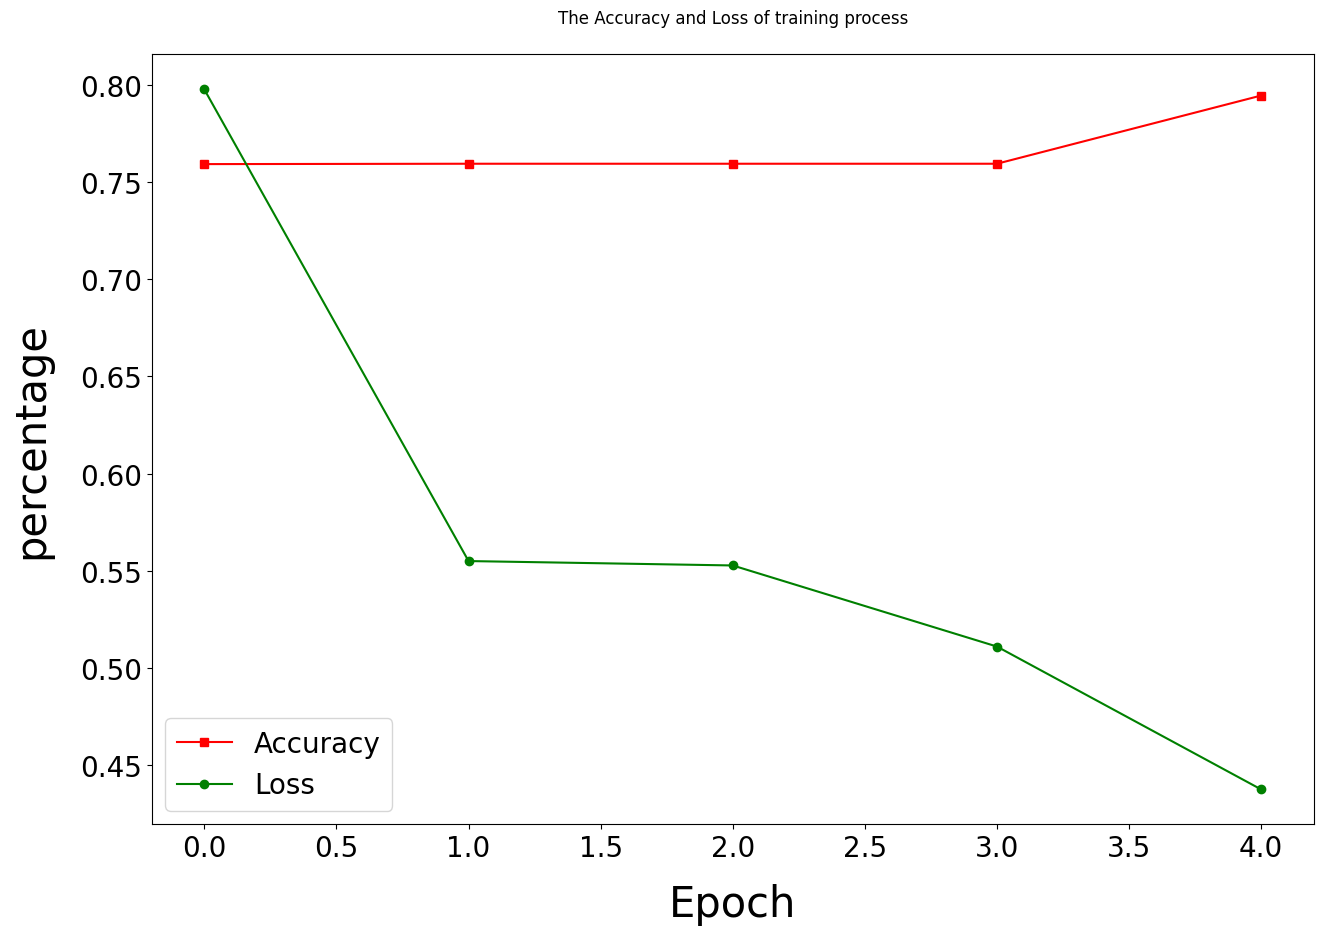

In [42]:
plotModelProcess(len(cnn_senti.epoch),  cnn_senti.history['accuracy'], cnn_senti.history['loss'])

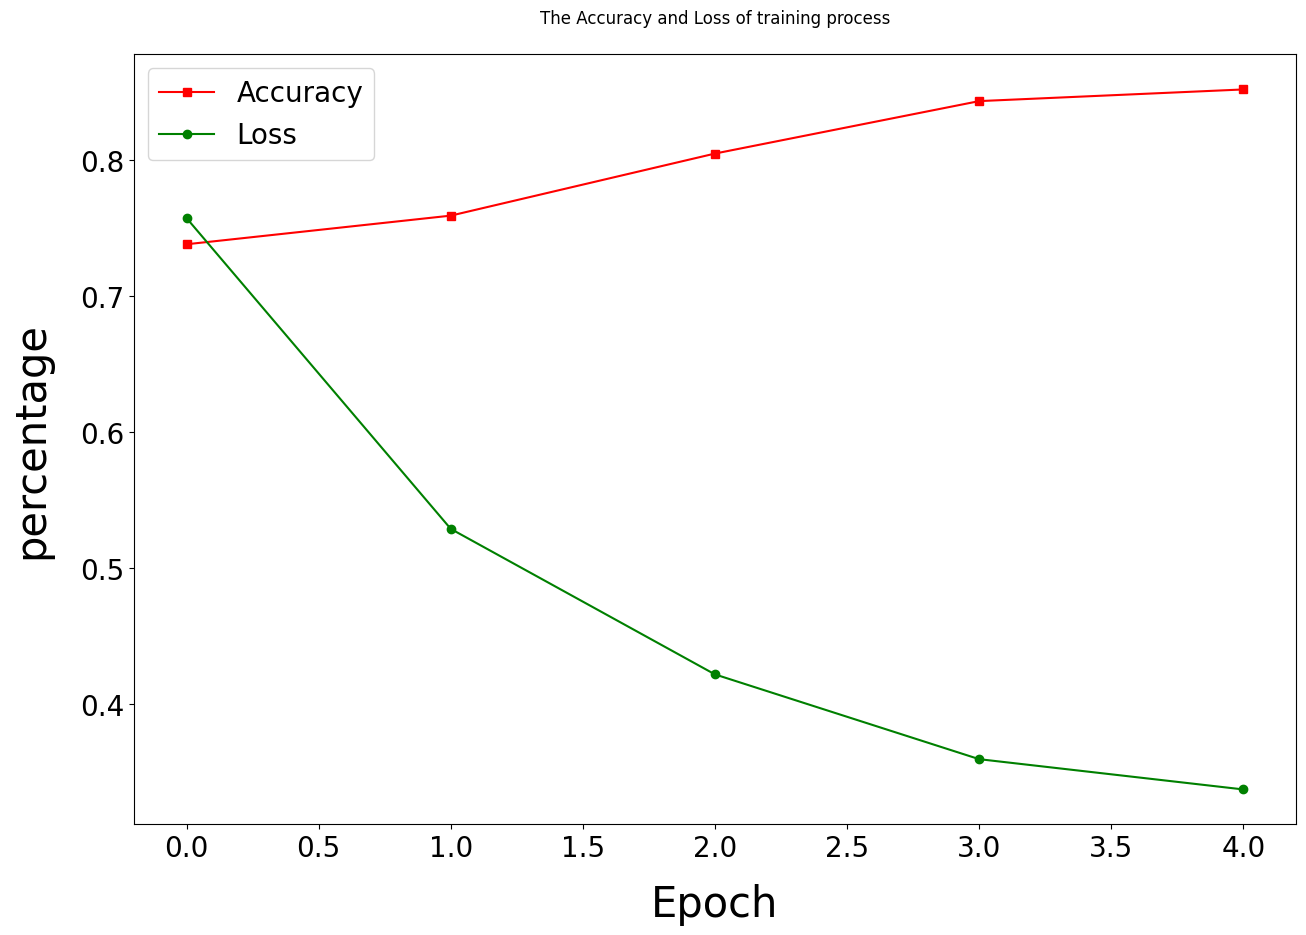

In [43]:
plotModelProcess(len(LSTM_senti.epoch),  LSTM_senti.history['accuracy'], LSTM_senti.history['loss'])